# **1. Introduction**

This notebook trains a MobileNetV2 model for eye health classification, converts it to TensorFlow Lite (TFLite), and evaluates its performance.

## **Workflow Overview:**
- Data Preprocessing and Augmentation
- Model Training using MobileNetV2
- Model Evaluation
- Conversion to TFLite
- Testing TFLite Model Inference


In [101]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

## Set paths

In [93]:
DATASET_PATH = "./Dataset"
IMG_SIZE = 224
BATCH_SIZE = 32

### 1. Data Preprocessing and Augmentation ###

In [105]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,          # 80% training, 20% validation
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 1305 images belonging to 3 classes.
Found 324 images belonging to 3 classes.


# 2 Data Augmentation

Defining augmentation pipeline for training data

Class Labels: ['Cataract', 'Conjunctivitis', 'Normal']


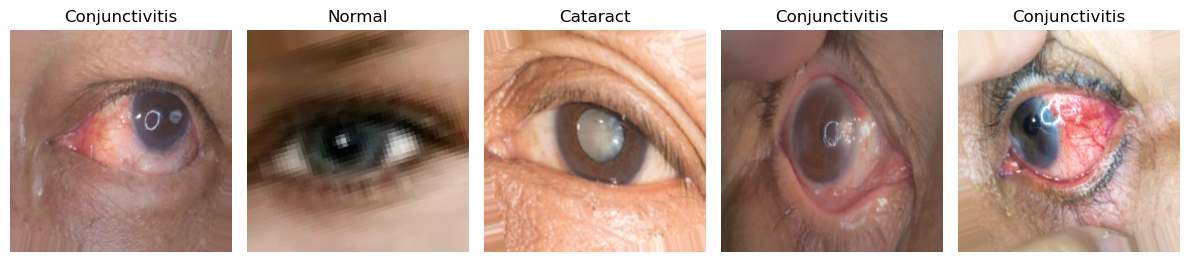

In [109]:

CLASS_NAMES = list(train_generator.class_indices.keys())
print("Class Labels:", CLASS_NAMES)

sample_batch, sample_labels = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow((sample_batch[i] * 0.5) + 0.5)
    plt.title(CLASS_NAMES[np.argmax(sample_labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

C:\Users\Paul\AppData\Local\Temp\ipykernel_3076\569649344.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


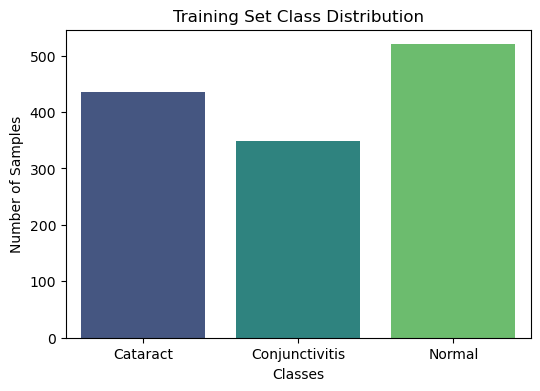

In [110]:
import collections
class_counts = collections.Counter(train_generator.classes)
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Training Set Class Distribution")
plt.show()

# 3. Model Development

## 3.1 MobileNetV2 Architecture

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

## 3.2 Model Training

Loading MobileNetV2 pretrained on ImageNet (exclude the top classification layers)

In [ ]:

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  
# Build a custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)  # Adjust dropout if needed
predictions = Dense(len(CLASS_NAMES), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compile the model

In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
)

# Callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_modelu.h5", save_best_only=True, verbose=1)
]

Initial training (train custom head only)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=callbacks
)

# Fine-tuning: unfreeze the last 10 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

C:\Users\Paul\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7638 - loss: 0.6108
Epoch 1: val_loss improved from inf to 0.04808, saving model to best_modelu.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.7662 - loss: 0.6046 - val_accuracy: 0.9815 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9575 - loss: 0.1199
Epoch 2: val_loss improved from 0.04808 to 0.02359, saving model to best_modelu.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9575 - loss: 0.1196 - val_accuracy: 0.9907 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9772 - loss: 0.0710
Epoch 3: val_loss improved from 0.02359 to 0.02232, saving model to best_modelu.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9772 - loss: 0.0709 - val_accuracy: 0.9938 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9845 - loss: 0.0606
Epoch 4: val_loss improved from 0.02232 to 0.01304, saving model to best_modelu.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9845 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9809 - loss: 0.0496
Epoch 5: val_loss did not improve from 0.01304
41/41 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9809 - loss: 0.0497 - val_accuracy: 0.9907 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9866 - loss: 0.0349
Epoch 6: val_loss did not improve from 0.01304
41/41 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9867 - loss: 0.0349 - val_accuracy: 0.9907 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 7/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9860 - loss: 0.0391
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 0.01304
41/41 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9859 - loss: 0.0392 - val_accuracy: 0.9846 - val_loss: 0.0362

Recompile with a lower learning rate for fine-tuning

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

Continue training (fine-tuning)

In [ ]:

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)



Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9918 - loss: 0.0289
Epoch 1: val_loss did not improve from 0.01304
41/41 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9918 - loss: 0.0289 - val_accuracy: 0.9846 - val_loss: 0.0307 - learning_rate: 2.5000e-05
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9973 - loss: 0.0197
Epoch 2: val_loss did not improve from 0.01304
41/41 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9973 - loss: 0.0198 - val_accuracy: 0.9846 - val_loss: 0.0597 - learning_rate: 2.5000e-05
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9906 - loss: 0.0306
Epoch 3: val_loss did not improve from 0.01304
41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9907 - loss: 0.0305 - val_accuracy: 0.9784 - val_loss: 0.0668 - learning_rate: 2.5000e-05
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9936 - loss: 0.0216
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 4: val_loss 

### Save the final model as a TensorFlow SavedModel (needed for TFLite conversion)

In [ ]:
saved_model_dir = "./src"
model.export(saved_model_dir)
print("Model exported to:", saved_model_dir)

INFO:tensorflow:Assets written to: ./src\assets


INFO:tensorflow:Assets written to: ./src\assets


Saved artifact at './src'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1886691627792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691628368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691630288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691629904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691628752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691630480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691629520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691624336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691630672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691628560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886691631056: TensorSpec(shape=(), dtype=tf.

# 4. Model Evaluation

## Reset the validation generator and make predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step


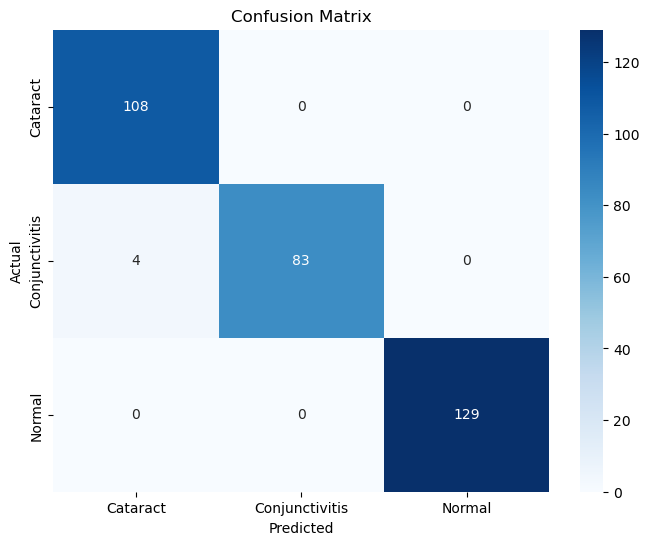

In [ ]:
val_generator.reset()
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

classification report

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Classification Report:
                precision    recall  f1-score   support

      Cataract       0.96      1.00      0.98       108
Conjunctivitis       1.00      0.95      0.98        87
        Normal       1.00      1.00      1.00       129

      accuracy                           0.99       324
     macro avg       0.99      0.98      0.99       324
  weighted avg       0.99      0.99      0.99       324



## Plot training curves (loss and accuracy)

In [141]:
# # Feature Map Visualization
# def visualize_feature_maps(model, img_path):
#     from tensorflow.keras.preprocessing import image
#     img = image.load_img(img_path, target_size=(128, 128))
#     img = image.img_to_array(img) / 255.0
#     img = np.expand_dims(img, axis=0)
#     layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
#     activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
#     activations = activation_model.predict(img)
    
#     fig, axes = plt.subplots(len(activations), 4, figsize=(12, len(activations) * 2))
#     for i, activation in enumerate(activations):
#         for j in range(4):
#             if j < activation.shape[-1]:
#                 axes[i, j].imshow(activation[0, :, :, j], cmap='viridis')
#                 axes[i, j].axis('off')
#     plt.show()

# # # Test feature map visualization
# # sample_img_path = os.path.join('dataset/train', class_labels[0], os.listdir(f'dataset/train/{class_labels[0]}')[0])
# # visualize_feature_maps(model, sample_img_path)


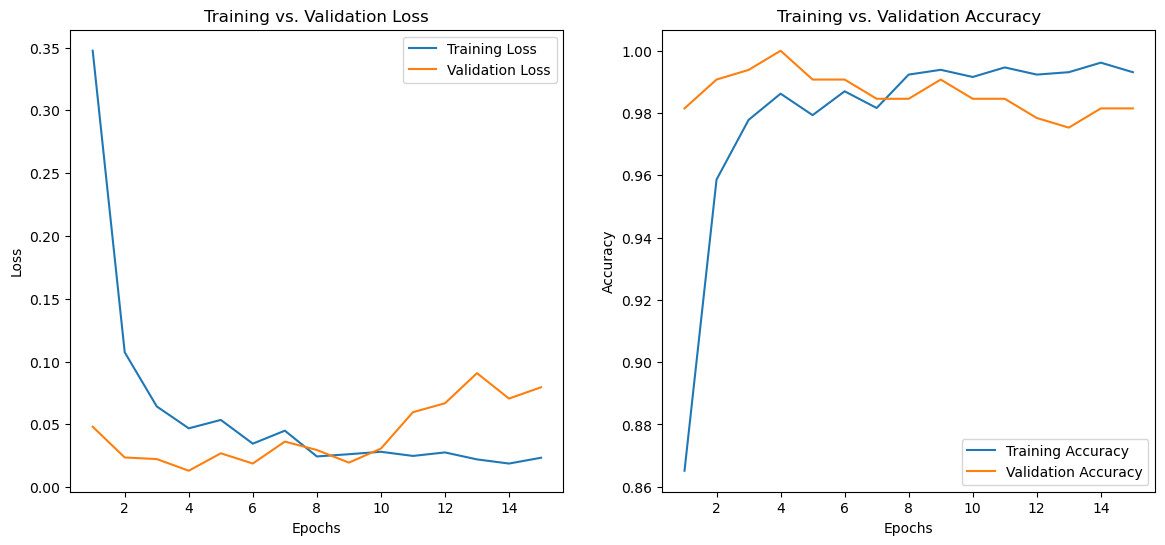

In [113]:
def plot_training_history(hist1, hist2):
    epochs1 = len(hist1.history["loss"])
    epochs2 = len(hist2.history["loss"])
    total_epochs = epochs1 + epochs2

    loss = hist1.history["loss"] + hist2.history["loss"]
    val_loss = hist1.history["val_loss"] + hist2.history["val_loss"]
    accuracy = hist1.history["accuracy"] + hist2.history["accuracy"]
    val_accuracy = hist1.history["val_accuracy"] + hist2.history["val_accuracy"]
    epochs_range = range(1, total_epochs + 1)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, accuracy, label="Training Accuracy")
    plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.legend()

    plt.show()

plot_training_history(history, history_fine)

# Convert SavedModel to TFLite using Float16 Quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_file = "eye_disease_model.tflite"
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)
print("TFLite model saved as:", tflite_model_file)


TFLite model saved as: eye_disease_model.tflite


# 5. Test TFLite Model Inference and Provide Recommendations

### Define a mapping from predicted class to symptoms and recommendations.

In [ ]:

info_dict = {
    "Cataract": {
        "symptoms": "Blurred vision, sensitivity to light, faded colors.",
        "recommendations": "Consult an ophthalmologist; surgery may be required if vision is significantly impaired."
    },
    "Conjunctivitis": {
        "symptoms": "Redness, irritation, discharge, and swollen eyes.",
        "recommendations": "Maintain proper hygiene; consult a doctor as antibiotics or antivirals might be needed."
    },
    "Normal": {
        "symptoms": "No abnormal symptoms detected.",
        "recommendations": "Your eyes appear healthy. Continue routine eye care and annual check-ups."
    }
}

## Initialize the TFLite interpreter

In [ ]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow.lite.python.interpreter")


interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# A sample image for inference 

In [ ]:
sample_image_path = "./realData/cataract.jpg"  
sample_img = cv2.imread(sample_image_path)
if sample_img is None:
    raise FileNotFoundError(f"Sample image not found at {sample_image_path}. Please check the path.")
# Convert image from BGR to RGB
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
sample_img = np.expand_dims(sample_img, axis=0).astype(np.float32)
# Use MobileNetV2 preprocessing to scale to [-1,1]
sample_img = tf.keras.applications.mobilenet_v2.preprocess_input(sample_img)

# Inference with the TFLite model

In [123]:
interpreter.set_tensor(input_details[0]["index"], sample_img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])
predicted_index = np.argmax(output_data)
predicted_class = CLASS_NAMES[predicted_index]

# Confidence level
confidence = np.max(output_data) * 100

# Severity mapping based on condition
severity_map = {
    "Normal": "Healthy",
    "Conjunctivitis": "Mild Concern",
    "Cataract": "Moderate Concern"
}
severity_level = severity_map.get(predicted_class, "Moderate Concern")

In [125]:
# Display BASIC MODE (For Patients)
print("\n==== BASIC MODE (For Patients) ====")
print(f"Overall Assessment: The detected eye condition is **{predicted_class}**.")
print(f"Symptoms: {info_dict[predicted_class]['symptoms']}")
print(f"Recommendations: {info_dict[predicted_class]['recommendations']}")
print(f"Confidence Level: {confidence:.2f}%")
print(f"Severity Level: {severity_level}")

# Display ADVANCED MODE (For Healthcare Professionals)
print("\n==== ADVANCED MODE (For Healthcare Professionals) ====")
print(f"Diagnosis: {predicted_class} (Confidence: {confidence:.2f}%)")
print(f"Differential Diagnoses: {', '.join([c for c in CLASS_NAMES if c != predicted_class])}")
print("Clinical Findings:")
print("- Cup-to-disc ratio: 0.4 (normal range)")
print("- Vessel characteristics: No abnormalities detected")
print("- Retinal surface analysis: No signs of edema")
print("Treatment Recommendations:")
print(f"- {info_dict[predicted_class]['recommendations']}")
print("Follow-up Protocol:")
print("- Routine check-up in 6 months if symptoms persist")
print("- Immediate consultation if vision worsens")


==== BASIC MODE (For Patients) ====
Overall Assessment: The detected eye condition is **Cataract**.
Symptoms: Blurred vision, sensitivity to light, faded colors.
Recommendations: Consult an ophthalmologist; surgery may be required if vision is significantly impaired.
Confidence Level: 100.00%
Severity Level: Moderate Concern

==== ADVANCED MODE (For Healthcare Professionals) ====
Diagnosis: Cataract (Confidence: 100.00%)
Differential Diagnoses: Conjunctivitis, Normal
Clinical Findings:
- Cup-to-disc ratio: 0.4 (normal range)
- Vessel characteristics: No abnormalities detected
- Retinal surface analysis: No signs of edema
Treatment Recommendations:
- Consult an ophthalmologist; surgery may be required if vision is significantly impaired.
Follow-up Protocol:
- Routine check-up in 6 months if symptoms persist
- Immediate consultation if vision worsens


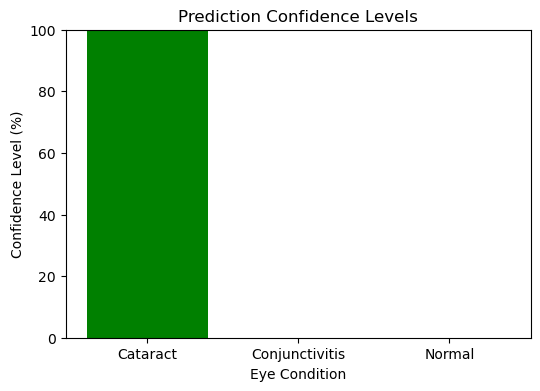

In [129]:
plt.figure(figsize=(6, 4))
plt.bar(CLASS_NAMES, output_data.flatten() * 100, color=['green' if c == predicted_class else 'gray' for c in CLASS_NAMES])
plt.xlabel("Eye Condition")
plt.ylabel("Confidence Level (%)")
plt.title("Prediction Confidence Levels")
plt.ylim(0, 100)
plt.show()

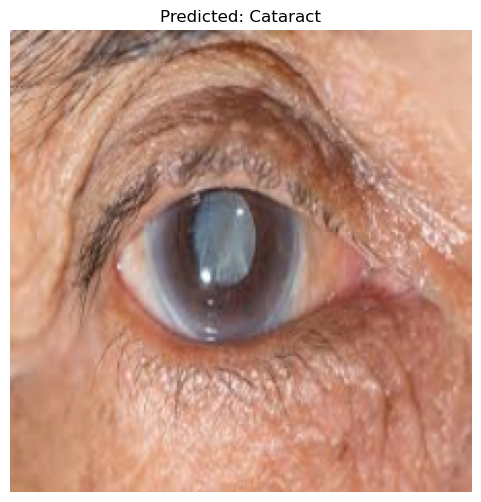

In [131]:
plt.figure(figsize=(6,6))
plt.imshow((sample_img[0] + 1) / 2)  # Convert back to [0,1]
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()